# Initialization
credits: https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier

In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras
from sklearn.metrics import f1_score as off1

E:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Global parameters
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 20
NUM_CLASS = 28
VAL_RATIO = 0.2
DIR = ''

warnings.filterwarnings("ignore")

In [3]:
# Data Set
path_to_train = DIR + 'train/'
data = pd.read_csv(DIR + 'train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=VAL_RATIO, random_state=42)

In [4]:
# Data Generator
class data_generator:
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, NUM_CLASS))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))
        
        image = np.stack((
            R/2 + B/2, 
            Y/2 + B/2, 
            G),-1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):                  # randomly process images to create more samples
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [5]:
# CNN
def create_model(input_shape, n_out):
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [6]:
# Evaluation criteria: f1 score
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [7]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

# Training

In [8]:
# Create model
keras.backend.clear_session()

model = create_model(
    input_shape = INPUT_SHAPE, 
    n_out = NUM_CLASS)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
__________

In [9]:
# Create data train for training and validation
checkpointer = ModelCheckpoint(DIR + 'InceptionResNetV2.model',monitor='val_loss',verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

train_generator = data_generator.create_train(train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=True)
validation_generator = data_generator.create_train(train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

In [10]:
# Train model
model.layers[2].trainable = True

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=50, 
    verbose=1,
    callbacks=[checkpointer,reduceLROnPlato])

Epoch 1/50
100/100 [==============================] - ETA: 1:06:32 - loss: 0.8798 - acc: 0.4982 - f1: 0.083 - ETA: 33:41 - loss: 0.6117 - acc: 0.6875 - f1: 0.0651  - ETA: 22:43 - loss: 0.4771 - acc: 0.7732 - f1: 0.070 - ETA: 17:14 - loss: 0.4408 - acc: 0.8112 - f1: 0.063 - ETA: 13:56 - loss: 0.4167 - acc: 0.8336 - f1: 0.057 - ETA: 11:43 - loss: 0.3979 - acc: 0.8476 - f1: 0.051 - ETA: 10:09 - loss: 0.3705 - acc: 0.8589 - f1: 0.056 - ETA: 8:57 - loss: 0.3530 - acc: 0.8667 - f1: 0.058 - ETA: 8:02 - loss: 0.3434 - acc: 0.8732 - f1: 0.05 - ETA: 7:17 - loss: 0.3342 - acc: 0.8786 - f1: 0.05 - ETA: 6:40 - loss: 0.3249 - acc: 0.8823 - f1: 0.05 - ETA: 6:10 - loss: 0.3131 - acc: 0.8878 - f1: 0.05 - ETA: 5:43 - loss: 0.3063 - acc: 0.8915 - f1: 0.05 - ETA: 5:21 - loss: 0.3007 - acc: 0.8941 - f1: 0.05 - ETA: 5:01 - loss: 0.2928 - acc: 0.8975 - f1: 0.05 - ETA: 4:44 - loss: 0.2868 - acc: 0.9006 - f1: 0.05 - ETA: 4:29 - loss: 0.2816 - acc: 0.9030 - f1: 0.05 - ETA: 4:15 - loss: 0.2772 - acc: 0.9045 - f1

100/100 [==============================] - ETA: 1:33 - loss: 0.1766 - acc: 0.9393 - f1: 0.07 - ETA: 1:31 - loss: 0.1797 - acc: 0.9437 - f1: 0.06 - ETA: 1:30 - loss: 0.1918 - acc: 0.9387 - f1: 0.06 - ETA: 1:29 - loss: 0.1940 - acc: 0.9375 - f1: 0.06 - ETA: 1:28 - loss: 0.1917 - acc: 0.9375 - f1: 0.06 - ETA: 1:27 - loss: 0.1897 - acc: 0.9387 - f1: 0.06 - ETA: 1:26 - loss: 0.1889 - acc: 0.9383 - f1: 0.06 - ETA: 1:25 - loss: 0.1850 - acc: 0.9397 - f1: 0.06 - ETA: 1:24 - loss: 0.1825 - acc: 0.9405 - f1: 0.06 - ETA: 1:23 - loss: 0.1836 - acc: 0.9398 - f1: 0.06 - ETA: 1:22 - loss: 0.1839 - acc: 0.9388 - f1: 0.06 - ETA: 1:22 - loss: 0.1818 - acc: 0.9402 - f1: 0.06 - ETA: 1:21 - loss: 0.1818 - acc: 0.9408 - f1: 0.06 - ETA: 1:20 - loss: 0.1807 - acc: 0.9411 - f1: 0.06 - ETA: 1:19 - loss: 0.1790 - acc: 0.9421 - f1: 0.05 - ETA: 1:18 - loss: 0.1777 - acc: 0.9425 - f1: 0.05 - ETA: 1:17 - loss: 0.1803 - acc: 0.9416 - f1: 0.06 - ETA: 1:16 - loss: 0.1804 - acc: 0.9415 - f1: 0.06 - ETA: 1:15 - loss: 0.1

100/100 [==============================] - ETA: 1:32 - loss: 0.1698 - acc: 0.9518 - f1: 0.07 - ETA: 1:31 - loss: 0.1511 - acc: 0.9536 - f1: 0.08 - ETA: 1:30 - loss: 0.1537 - acc: 0.9518 - f1: 0.07 - ETA: 1:29 - loss: 0.1587 - acc: 0.9509 - f1: 0.07 - ETA: 1:29 - loss: 0.1596 - acc: 0.9489 - f1: 0.07 - ETA: 1:28 - loss: 0.1581 - acc: 0.9491 - f1: 0.07 - ETA: 1:27 - loss: 0.1605 - acc: 0.9485 - f1: 0.07 - ETA: 1:26 - loss: 0.1606 - acc: 0.9484 - f1: 0.07 - ETA: 1:25 - loss: 0.1616 - acc: 0.9480 - f1: 0.07 - ETA: 1:25 - loss: 0.1633 - acc: 0.9477 - f1: 0.06 - ETA: 1:24 - loss: 0.1611 - acc: 0.9476 - f1: 0.06 - ETA: 1:23 - loss: 0.1632 - acc: 0.9476 - f1: 0.06 - ETA: 1:22 - loss: 0.1624 - acc: 0.9473 - f1: 0.06 - ETA: 1:21 - loss: 0.1624 - acc: 0.9474 - f1: 0.06 - ETA: 1:20 - loss: 0.1653 - acc: 0.9468 - f1: 0.06 - ETA: 1:19 - loss: 0.1664 - acc: 0.9460 - f1: 0.06 - ETA: 1:18 - loss: 0.1654 - acc: 0.9463 - f1: 0.06 - ETA: 1:17 - loss: 0.1655 - acc: 0.9465 - f1: 0.06 - ETA: 1:16 - loss: 0.1

100/100 [==============================] - ETA: 1:32 - loss: 0.1481 - acc: 0.9536 - f1: 0.07 - ETA: 1:31 - loss: 0.1497 - acc: 0.9509 - f1: 0.06 - ETA: 1:31 - loss: 0.1544 - acc: 0.9506 - f1: 0.06 - ETA: 1:31 - loss: 0.1527 - acc: 0.9527 - f1: 0.06 - ETA: 1:30 - loss: 0.1508 - acc: 0.9511 - f1: 0.06 - ETA: 1:29 - loss: 0.1582 - acc: 0.9503 - f1: 0.06 - ETA: 1:28 - loss: 0.1608 - acc: 0.9495 - f1: 0.06 - ETA: 1:27 - loss: 0.1637 - acc: 0.9475 - f1: 0.06 - ETA: 1:26 - loss: 0.1645 - acc: 0.9470 - f1: 0.07 - ETA: 1:25 - loss: 0.1637 - acc: 0.9479 - f1: 0.07 - ETA: 1:24 - loss: 0.1631 - acc: 0.9479 - f1: 0.07 - ETA: 1:24 - loss: 0.1628 - acc: 0.9475 - f1: 0.07 - ETA: 1:23 - loss: 0.1621 - acc: 0.9477 - f1: 0.07 - ETA: 1:22 - loss: 0.1624 - acc: 0.9474 - f1: 0.07 - ETA: 1:21 - loss: 0.1612 - acc: 0.9479 - f1: 0.07 - ETA: 1:20 - loss: 0.1615 - acc: 0.9474 - f1: 0.07 - ETA: 1:19 - loss: 0.1596 - acc: 0.9478 - f1: 0.07 - ETA: 1:18 - loss: 0.1604 - acc: 0.9475 - f1: 0.07 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1633 - acc: 0.9482 - f1: 0.07 - ETA: 1:33 - loss: 0.1695 - acc: 0.9455 - f1: 0.07 - ETA: 1:32 - loss: 0.1701 - acc: 0.9458 - f1: 0.07 - ETA: 1:31 - loss: 0.1705 - acc: 0.9455 - f1: 0.07 - ETA: 1:30 - loss: 0.1695 - acc: 0.9450 - f1: 0.07 - ETA: 1:29 - loss: 0.1712 - acc: 0.9440 - f1: 0.07 - ETA: 1:28 - loss: 0.1689 - acc: 0.9439 - f1: 0.07 - ETA: 1:27 - loss: 0.1657 - acc: 0.9444 - f1: 0.07 - ETA: 1:26 - loss: 0.1667 - acc: 0.9442 - f1: 0.07 - ETA: 1:25 - loss: 0.1671 - acc: 0.9446 - f1: 0.07 - ETA: 1:24 - loss: 0.1698 - acc: 0.9442 - f1: 0.07 - ETA: 1:23 - loss: 0.1668 - acc: 0.9454 - f1: 0.07 - ETA: 1:22 - loss: 0.1660 - acc: 0.9463 - f1: 0.07 - ETA: 1:21 - loss: 0.1678 - acc: 0.9458 - f1: 0.07 - ETA: 1:20 - loss: 0.1663 - acc: 0.9462 - f1: 0.07 - ETA: 1:19 - loss: 0.1641 - acc: 0.9463 - f1: 0.07 - ETA: 1:19 - loss: 0.1655 - acc: 0.9460 - f1: 0.07 - ETA: 1:18 - loss: 0.1667 - acc: 0.9460 - f1: 0.07 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1895 - acc: 0.9357 - f1: 0.07 - ETA: 1:34 - loss: 0.1658 - acc: 0.9429 - f1: 0.07 - ETA: 1:32 - loss: 0.1605 - acc: 0.9440 - f1: 0.08 - ETA: 1:31 - loss: 0.1594 - acc: 0.9464 - f1: 0.08 - ETA: 1:30 - loss: 0.1536 - acc: 0.9479 - f1: 0.08 - ETA: 1:30 - loss: 0.1532 - acc: 0.9476 - f1: 0.08 - ETA: 1:29 - loss: 0.1529 - acc: 0.9474 - f1: 0.08 - ETA: 1:28 - loss: 0.1538 - acc: 0.9467 - f1: 0.08 - ETA: 1:27 - loss: 0.1557 - acc: 0.9456 - f1: 0.08 - ETA: 1:26 - loss: 0.1589 - acc: 0.9450 - f1: 0.08 - ETA: 1:25 - loss: 0.1596 - acc: 0.9450 - f1: 0.08 - ETA: 1:24 - loss: 0.1599 - acc: 0.9452 - f1: 0.08 - ETA: 1:23 - loss: 0.1605 - acc: 0.9453 - f1: 0.08 - ETA: 1:22 - loss: 0.1604 - acc: 0.9450 - f1: 0.08 - ETA: 1:21 - loss: 0.1596 - acc: 0.9458 - f1: 0.08 - ETA: 1:20 - loss: 0.1603 - acc: 0.9461 - f1: 0.08 - ETA: 1:19 - loss: 0.1611 - acc: 0.9462 - f1: 0.08 - ETA: 1:18 - loss: 0.1596 - acc: 0.9471 - f1: 0.08 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:35 - loss: 0.1459 - acc: 0.9464 - f1: 0.08 - ETA: 1:34 - loss: 0.1535 - acc: 0.9446 - f1: 0.08 - ETA: 1:33 - loss: 0.1478 - acc: 0.9470 - f1: 0.09 - ETA: 1:32 - loss: 0.1469 - acc: 0.9496 - f1: 0.08 - ETA: 1:31 - loss: 0.1440 - acc: 0.9511 - f1: 0.08 - ETA: 1:30 - loss: 0.1462 - acc: 0.9491 - f1: 0.09 - ETA: 1:29 - loss: 0.1482 - acc: 0.9482 - f1: 0.08 - ETA: 1:28 - loss: 0.1482 - acc: 0.9491 - f1: 0.08 - ETA: 1:27 - loss: 0.1460 - acc: 0.9500 - f1: 0.08 - ETA: 1:26 - loss: 0.1450 - acc: 0.9504 - f1: 0.08 - ETA: 1:25 - loss: 0.1483 - acc: 0.9495 - f1: 0.08 - ETA: 1:24 - loss: 0.1453 - acc: 0.9509 - f1: 0.08 - ETA: 1:23 - loss: 0.1447 - acc: 0.9510 - f1: 0.08 - ETA: 1:22 - loss: 0.1479 - acc: 0.9509 - f1: 0.09 - ETA: 1:21 - loss: 0.1496 - acc: 0.9502 - f1: 0.09 - ETA: 1:20 - loss: 0.1498 - acc: 0.9504 - f1: 0.09 - ETA: 1:19 - loss: 0.1499 - acc: 0.9503 - f1: 0.09 - ETA: 1:18 - loss: 0.1493 - acc: 0.9503 - f1: 0.08 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1556 - acc: 0.9446 - f1: 0.10 - ETA: 1:33 - loss: 0.1618 - acc: 0.9446 - f1: 0.09 - ETA: 1:32 - loss: 0.1588 - acc: 0.9440 - f1: 0.09 - ETA: 1:31 - loss: 0.1558 - acc: 0.9460 - f1: 0.09 - ETA: 1:30 - loss: 0.1569 - acc: 0.9457 - f1: 0.09 - ETA: 1:29 - loss: 0.1547 - acc: 0.9461 - f1: 0.09 - ETA: 1:28 - loss: 0.1528 - acc: 0.9482 - f1: 0.09 - ETA: 1:27 - loss: 0.1510 - acc: 0.9480 - f1: 0.09 - ETA: 1:26 - loss: 0.1535 - acc: 0.9472 - f1: 0.09 - ETA: 1:25 - loss: 0.1525 - acc: 0.9475 - f1: 0.09 - ETA: 1:25 - loss: 0.1533 - acc: 0.9476 - f1: 0.09 - ETA: 1:24 - loss: 0.1514 - acc: 0.9476 - f1: 0.09 - ETA: 1:23 - loss: 0.1515 - acc: 0.9475 - f1: 0.09 - ETA: 1:22 - loss: 0.1532 - acc: 0.9471 - f1: 0.09 - ETA: 1:21 - loss: 0.1514 - acc: 0.9474 - f1: 0.09 - ETA: 1:20 - loss: 0.1502 - acc: 0.9478 - f1: 0.09 - ETA: 1:19 - loss: 0.1484 - acc: 0.9485 - f1: 0.10 - ETA: 1:18 - loss: 0.1470 - acc: 0.9486 - f1: 0.10 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1197 - acc: 0.9571 - f1: 0.10 - ETA: 1:33 - loss: 0.1178 - acc: 0.9589 - f1: 0.11 - ETA: 1:32 - loss: 0.1283 - acc: 0.9542 - f1: 0.10 - ETA: 1:31 - loss: 0.1368 - acc: 0.9527 - f1: 0.09 - ETA: 1:30 - loss: 0.1335 - acc: 0.9546 - f1: 0.09 - ETA: 1:29 - loss: 0.1322 - acc: 0.9548 - f1: 0.09 - ETA: 1:29 - loss: 0.1368 - acc: 0.9536 - f1: 0.10 - ETA: 1:28 - loss: 0.1387 - acc: 0.9527 - f1: 0.10 - ETA: 1:27 - loss: 0.1419 - acc: 0.9510 - f1: 0.10 - ETA: 1:26 - loss: 0.1397 - acc: 0.9516 - f1: 0.10 - ETA: 1:25 - loss: 0.1404 - acc: 0.9505 - f1: 0.10 - ETA: 1:24 - loss: 0.1407 - acc: 0.9506 - f1: 0.10 - ETA: 1:23 - loss: 0.1399 - acc: 0.9505 - f1: 0.10 - ETA: 1:22 - loss: 0.1423 - acc: 0.9503 - f1: 0.10 - ETA: 1:21 - loss: 0.1416 - acc: 0.9506 - f1: 0.09 - ETA: 1:20 - loss: 0.1413 - acc: 0.9504 - f1: 0.10 - ETA: 1:19 - loss: 0.1406 - acc: 0.9508 - f1: 0.10 - ETA: 1:18 - loss: 0.1404 - acc: 0.9510 - f1: 0.10 - ETA: 1:18 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1306 - acc: 0.9589 - f1: 0.10 - ETA: 1:34 - loss: 0.1144 - acc: 0.9616 - f1: 0.13 - ETA: 1:33 - loss: 0.1266 - acc: 0.9577 - f1: 0.13 - ETA: 1:32 - loss: 0.1332 - acc: 0.9518 - f1: 0.12 - ETA: 1:31 - loss: 0.1360 - acc: 0.9521 - f1: 0.12 - ETA: 1:30 - loss: 0.1313 - acc: 0.9536 - f1: 0.12 - ETA: 1:29 - loss: 0.1341 - acc: 0.9528 - f1: 0.11 - ETA: 1:28 - loss: 0.1348 - acc: 0.9542 - f1: 0.12 - ETA: 1:27 - loss: 0.1357 - acc: 0.9540 - f1: 0.12 - ETA: 1:26 - loss: 0.1393 - acc: 0.9539 - f1: 0.12 - ETA: 1:25 - loss: 0.1388 - acc: 0.9537 - f1: 0.12 - ETA: 1:24 - loss: 0.1391 - acc: 0.9537 - f1: 0.12 - ETA: 1:23 - loss: 0.1390 - acc: 0.9536 - f1: 0.11 - ETA: 1:22 - loss: 0.1411 - acc: 0.9533 - f1: 0.11 - ETA: 1:21 - loss: 0.1399 - acc: 0.9537 - f1: 0.12 - ETA: 1:20 - loss: 0.1394 - acc: 0.9538 - f1: 0.11 - ETA: 1:19 - loss: 0.1405 - acc: 0.9528 - f1: 0.11 - ETA: 1:18 - loss: 0.1408 - acc: 0.9523 - f1: 0.11 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1476 - acc: 0.9554 - f1: 0.11 - ETA: 1:34 - loss: 0.1376 - acc: 0.9527 - f1: 0.12 - ETA: 1:32 - loss: 0.1445 - acc: 0.9500 - f1: 0.11 - ETA: 1:31 - loss: 0.1459 - acc: 0.9500 - f1: 0.11 - ETA: 1:30 - loss: 0.1449 - acc: 0.9507 - f1: 0.12 - ETA: 1:29 - loss: 0.1363 - acc: 0.9542 - f1: 0.12 - ETA: 1:28 - loss: 0.1363 - acc: 0.9536 - f1: 0.12 - ETA: 1:27 - loss: 0.1435 - acc: 0.9516 - f1: 0.12 - ETA: 1:26 - loss: 0.1467 - acc: 0.9502 - f1: 0.12 - ETA: 1:25 - loss: 0.1479 - acc: 0.9496 - f1: 0.12 - ETA: 1:24 - loss: 0.1479 - acc: 0.9489 - f1: 0.12 - ETA: 1:23 - loss: 0.1478 - acc: 0.9485 - f1: 0.12 - ETA: 1:23 - loss: 0.1449 - acc: 0.9499 - f1: 0.12 - ETA: 1:22 - loss: 0.1474 - acc: 0.9490 - f1: 0.12 - ETA: 1:21 - loss: 0.1467 - acc: 0.9496 - f1: 0.12 - ETA: 1:20 - loss: 0.1462 - acc: 0.9497 - f1: 0.11 - ETA: 1:19 - loss: 0.1468 - acc: 0.9497 - f1: 0.12 - ETA: 1:18 - loss: 0.1485 - acc: 0.9497 - f1: 0.12 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1199 - acc: 0.9625 - f1: 0.16 - ETA: 1:32 - loss: 0.1257 - acc: 0.9580 - f1: 0.15 - ETA: 1:32 - loss: 0.1148 - acc: 0.9619 - f1: 0.15 - ETA: 1:31 - loss: 0.1229 - acc: 0.9576 - f1: 0.14 - ETA: 1:30 - loss: 0.1228 - acc: 0.9575 - f1: 0.14 - ETA: 1:29 - loss: 0.1227 - acc: 0.9574 - f1: 0.14 - ETA: 1:28 - loss: 0.1235 - acc: 0.9582 - f1: 0.14 - ETA: 1:27 - loss: 0.1281 - acc: 0.9565 - f1: 0.14 - ETA: 1:26 - loss: 0.1304 - acc: 0.9550 - f1: 0.14 - ETA: 1:25 - loss: 0.1317 - acc: 0.9545 - f1: 0.14 - ETA: 1:24 - loss: 0.1317 - acc: 0.9554 - f1: 0.14 - ETA: 1:24 - loss: 0.1308 - acc: 0.9560 - f1: 0.14 - ETA: 1:23 - loss: 0.1307 - acc: 0.9556 - f1: 0.14 - ETA: 1:22 - loss: 0.1296 - acc: 0.9561 - f1: 0.14 - ETA: 1:21 - loss: 0.1288 - acc: 0.9567 - f1: 0.14 - ETA: 1:20 - loss: 0.1300 - acc: 0.9562 - f1: 0.14 - ETA: 1:19 - loss: 0.1317 - acc: 0.9560 - f1: 0.14 - ETA: 1:18 - loss: 0.1324 - acc: 0.9562 - f1: 0.14 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1277 - acc: 0.9625 - f1: 0.16 - ETA: 1:32 - loss: 0.1323 - acc: 0.9589 - f1: 0.13 - ETA: 1:31 - loss: 0.1422 - acc: 0.9536 - f1: 0.13 - ETA: 1:31 - loss: 0.1436 - acc: 0.9527 - f1: 0.13 - ETA: 1:30 - loss: 0.1422 - acc: 0.9518 - f1: 0.12 - ETA: 1:29 - loss: 0.1387 - acc: 0.9530 - f1: 0.12 - ETA: 1:28 - loss: 0.1466 - acc: 0.9510 - f1: 0.12 - ETA: 1:27 - loss: 0.1442 - acc: 0.9522 - f1: 0.11 - ETA: 1:26 - loss: 0.1465 - acc: 0.9512 - f1: 0.12 - ETA: 1:26 - loss: 0.1441 - acc: 0.9520 - f1: 0.12 - ETA: 1:25 - loss: 0.1421 - acc: 0.9521 - f1: 0.12 - ETA: 1:24 - loss: 0.1418 - acc: 0.9522 - f1: 0.12 - ETA: 1:23 - loss: 0.1398 - acc: 0.9532 - f1: 0.12 - ETA: 1:22 - loss: 0.1389 - acc: 0.9540 - f1: 0.12 - ETA: 1:21 - loss: 0.1395 - acc: 0.9538 - f1: 0.12 - ETA: 1:20 - loss: 0.1388 - acc: 0.9539 - f1: 0.12 - ETA: 1:19 - loss: 0.1381 - acc: 0.9540 - f1: 0.12 - ETA: 1:18 - loss: 0.1376 - acc: 0.9540 - f1: 0.12 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1572 - acc: 0.9482 - f1: 0.09 - ETA: 1:33 - loss: 0.1383 - acc: 0.9563 - f1: 0.11 - ETA: 1:33 - loss: 0.1362 - acc: 0.9548 - f1: 0.11 - ETA: 1:32 - loss: 0.1334 - acc: 0.9571 - f1: 0.11 - ETA: 1:31 - loss: 0.1301 - acc: 0.9593 - f1: 0.13 - ETA: 1:30 - loss: 0.1349 - acc: 0.9574 - f1: 0.13 - ETA: 1:29 - loss: 0.1336 - acc: 0.9564 - f1: 0.13 - ETA: 1:28 - loss: 0.1327 - acc: 0.9551 - f1: 0.13 - ETA: 1:27 - loss: 0.1333 - acc: 0.9556 - f1: 0.13 - ETA: 1:26 - loss: 0.1318 - acc: 0.9554 - f1: 0.13 - ETA: 1:25 - loss: 0.1299 - acc: 0.9558 - f1: 0.14 - ETA: 1:24 - loss: 0.1280 - acc: 0.9561 - f1: 0.13 - ETA: 1:23 - loss: 0.1301 - acc: 0.9551 - f1: 0.13 - ETA: 1:22 - loss: 0.1273 - acc: 0.9556 - f1: 0.13 - ETA: 1:21 - loss: 0.1277 - acc: 0.9552 - f1: 0.13 - ETA: 1:20 - loss: 0.1276 - acc: 0.9549 - f1: 0.13 - ETA: 1:19 - loss: 0.1273 - acc: 0.9557 - f1: 0.13 - ETA: 1:18 - loss: 0.1278 - acc: 0.9557 - f1: 0.14 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1422 - acc: 0.9446 - f1: 0.14 - ETA: 1:33 - loss: 0.1413 - acc: 0.9509 - f1: 0.13 - ETA: 1:32 - loss: 0.1445 - acc: 0.9506 - f1: 0.13 - ETA: 1:31 - loss: 0.1394 - acc: 0.9522 - f1: 0.13 - ETA: 1:31 - loss: 0.1333 - acc: 0.9539 - f1: 0.15 - ETA: 1:30 - loss: 0.1323 - acc: 0.9542 - f1: 0.15 - ETA: 1:29 - loss: 0.1327 - acc: 0.9554 - f1: 0.15 - ETA: 1:28 - loss: 0.1334 - acc: 0.9547 - f1: 0.15 - ETA: 1:27 - loss: 0.1305 - acc: 0.9562 - f1: 0.16 - ETA: 1:26 - loss: 0.1312 - acc: 0.9561 - f1: 0.15 - ETA: 1:25 - loss: 0.1325 - acc: 0.9560 - f1: 0.15 - ETA: 1:24 - loss: 0.1317 - acc: 0.9560 - f1: 0.15 - ETA: 1:23 - loss: 0.1316 - acc: 0.9559 - f1: 0.15 - ETA: 1:22 - loss: 0.1320 - acc: 0.9561 - f1: 0.15 - ETA: 1:21 - loss: 0.1332 - acc: 0.9563 - f1: 0.15 - ETA: 1:20 - loss: 0.1323 - acc: 0.9565 - f1: 0.15 - ETA: 1:19 - loss: 0.1316 - acc: 0.9564 - f1: 0.15 - ETA: 1:18 - loss: 0.1302 - acc: 0.9565 - f1: 0.15 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1263 - acc: 0.9518 - f1: 0.10 - ETA: 1:33 - loss: 0.1273 - acc: 0.9518 - f1: 0.11 - ETA: 1:32 - loss: 0.1294 - acc: 0.9524 - f1: 0.11 - ETA: 1:31 - loss: 0.1333 - acc: 0.9527 - f1: 0.12 - ETA: 1:30 - loss: 0.1363 - acc: 0.9514 - f1: 0.12 - ETA: 1:29 - loss: 0.1383 - acc: 0.9509 - f1: 0.12 - ETA: 1:28 - loss: 0.1388 - acc: 0.9508 - f1: 0.13 - ETA: 1:28 - loss: 0.1379 - acc: 0.9511 - f1: 0.13 - ETA: 1:27 - loss: 0.1413 - acc: 0.9506 - f1: 0.13 - ETA: 1:26 - loss: 0.1413 - acc: 0.9502 - f1: 0.13 - ETA: 1:25 - loss: 0.1414 - acc: 0.9505 - f1: 0.14 - ETA: 1:24 - loss: 0.1394 - acc: 0.9516 - f1: 0.14 - ETA: 1:23 - loss: 0.1384 - acc: 0.9526 - f1: 0.13 - ETA: 1:22 - loss: 0.1406 - acc: 0.9519 - f1: 0.13 - ETA: 1:21 - loss: 0.1374 - acc: 0.9529 - f1: 0.14 - ETA: 1:20 - loss: 0.1361 - acc: 0.9527 - f1: 0.14 - ETA: 1:19 - loss: 0.1368 - acc: 0.9521 - f1: 0.14 - ETA: 1:18 - loss: 0.1365 - acc: 0.9524 - f1: 0.14 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1133 - acc: 0.9643 - f1: 0.16 - ETA: 1:33 - loss: 0.1153 - acc: 0.9589 - f1: 0.16 - ETA: 1:32 - loss: 0.1187 - acc: 0.9577 - f1: 0.17 - ETA: 1:31 - loss: 0.1290 - acc: 0.9549 - f1: 0.16 - ETA: 1:30 - loss: 0.1228 - acc: 0.9586 - f1: 0.16 - ETA: 1:29 - loss: 0.1213 - acc: 0.9595 - f1: 0.16 - ETA: 1:28 - loss: 0.1184 - acc: 0.9607 - f1: 0.16 - ETA: 1:28 - loss: 0.1149 - acc: 0.9623 - f1: 0.16 - ETA: 1:27 - loss: 0.1144 - acc: 0.9623 - f1: 0.16 - ETA: 1:26 - loss: 0.1160 - acc: 0.9613 - f1: 0.17 - ETA: 1:25 - loss: 0.1186 - acc: 0.9612 - f1: 0.16 - ETA: 1:24 - loss: 0.1197 - acc: 0.9609 - f1: 0.16 - ETA: 1:23 - loss: 0.1189 - acc: 0.9607 - f1: 0.16 - ETA: 1:22 - loss: 0.1193 - acc: 0.9607 - f1: 0.16 - ETA: 1:21 - loss: 0.1211 - acc: 0.9605 - f1: 0.16 - ETA: 1:20 - loss: 0.1206 - acc: 0.9605 - f1: 0.16 - ETA: 1:19 - loss: 0.1195 - acc: 0.9607 - f1: 0.16 - ETA: 1:18 - loss: 0.1195 - acc: 0.9603 - f1: 0.16 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1148 - acc: 0.9571 - f1: 0.15 - ETA: 1:33 - loss: 0.1078 - acc: 0.9634 - f1: 0.13 - ETA: 1:32 - loss: 0.1233 - acc: 0.9589 - f1: 0.13 - ETA: 1:31 - loss: 0.1226 - acc: 0.9594 - f1: 0.13 - ETA: 1:30 - loss: 0.1206 - acc: 0.9582 - f1: 0.14 - ETA: 1:29 - loss: 0.1202 - acc: 0.9571 - f1: 0.14 - ETA: 1:28 - loss: 0.1228 - acc: 0.9574 - f1: 0.14 - ETA: 1:27 - loss: 0.1210 - acc: 0.9587 - f1: 0.14 - ETA: 1:26 - loss: 0.1182 - acc: 0.9593 - f1: 0.14 - ETA: 1:25 - loss: 0.1160 - acc: 0.9595 - f1: 0.15 - ETA: 1:25 - loss: 0.1182 - acc: 0.9594 - f1: 0.15 - ETA: 1:24 - loss: 0.1195 - acc: 0.9586 - f1: 0.15 - ETA: 1:23 - loss: 0.1219 - acc: 0.9585 - f1: 0.15 - ETA: 1:22 - loss: 0.1244 - acc: 0.9575 - f1: 0.15 - ETA: 1:21 - loss: 0.1225 - acc: 0.9579 - f1: 0.15 - ETA: 1:20 - loss: 0.1215 - acc: 0.9579 - f1: 0.15 - ETA: 1:19 - loss: 0.1225 - acc: 0.9581 - f1: 0.15 - ETA: 1:18 - loss: 0.1222 - acc: 0.9583 - f1: 0.15 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1078 - acc: 0.9643 - f1: 0.18 - ETA: 1:33 - loss: 0.1167 - acc: 0.9616 - f1: 0.17 - ETA: 1:32 - loss: 0.1208 - acc: 0.9619 - f1: 0.16 - ETA: 1:31 - loss: 0.1213 - acc: 0.9603 - f1: 0.16 - ETA: 1:30 - loss: 0.1185 - acc: 0.9611 - f1: 0.16 - ETA: 1:29 - loss: 0.1194 - acc: 0.9595 - f1: 0.16 - ETA: 1:28 - loss: 0.1180 - acc: 0.9602 - f1: 0.16 - ETA: 1:27 - loss: 0.1201 - acc: 0.9587 - f1: 0.16 - ETA: 1:26 - loss: 0.1189 - acc: 0.9585 - f1: 0.16 - ETA: 1:26 - loss: 0.1189 - acc: 0.9582 - f1: 0.16 - ETA: 1:25 - loss: 0.1186 - acc: 0.9586 - f1: 0.16 - ETA: 1:24 - loss: 0.1164 - acc: 0.9591 - f1: 0.17 - ETA: 1:23 - loss: 0.1157 - acc: 0.9592 - f1: 0.16 - ETA: 1:22 - loss: 0.1153 - acc: 0.9596 - f1: 0.17 - ETA: 1:21 - loss: 0.1144 - acc: 0.9594 - f1: 0.17 - ETA: 1:20 - loss: 0.1158 - acc: 0.9592 - f1: 0.16 - ETA: 1:19 - loss: 0.1154 - acc: 0.9596 - f1: 0.16 - ETA: 1:18 - loss: 0.1164 - acc: 0.9595 - f1: 0.16 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1122 - acc: 0.9536 - f1: 0.14 - ETA: 1:33 - loss: 0.1105 - acc: 0.9563 - f1: 0.13 - ETA: 1:32 - loss: 0.1126 - acc: 0.9554 - f1: 0.13 - ETA: 1:31 - loss: 0.1076 - acc: 0.9567 - f1: 0.13 - ETA: 1:30 - loss: 0.1074 - acc: 0.9579 - f1: 0.14 - ETA: 1:29 - loss: 0.1127 - acc: 0.9574 - f1: 0.14 - ETA: 1:28 - loss: 0.1118 - acc: 0.9571 - f1: 0.15 - ETA: 1:28 - loss: 0.1102 - acc: 0.9585 - f1: 0.15 - ETA: 1:27 - loss: 0.1123 - acc: 0.9585 - f1: 0.15 - ETA: 1:26 - loss: 0.1154 - acc: 0.9577 - f1: 0.15 - ETA: 1:25 - loss: 0.1189 - acc: 0.9565 - f1: 0.15 - ETA: 1:24 - loss: 0.1171 - acc: 0.9577 - f1: 0.15 - ETA: 1:23 - loss: 0.1176 - acc: 0.9581 - f1: 0.15 - ETA: 1:22 - loss: 0.1175 - acc: 0.9582 - f1: 0.15 - ETA: 1:21 - loss: 0.1165 - acc: 0.9586 - f1: 0.15 - ETA: 1:20 - loss: 0.1170 - acc: 0.9584 - f1: 0.15 - ETA: 1:19 - loss: 0.1173 - acc: 0.9584 - f1: 0.15 - ETA: 1:18 - loss: 0.1164 - acc: 0.9589 - f1: 0.15 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1224 - acc: 0.9625 - f1: 0.17 - ETA: 1:33 - loss: 0.1313 - acc: 0.9607 - f1: 0.16 - ETA: 1:32 - loss: 0.1332 - acc: 0.9577 - f1: 0.16 - ETA: 1:32 - loss: 0.1331 - acc: 0.9594 - f1: 0.15 - ETA: 1:31 - loss: 0.1284 - acc: 0.9589 - f1: 0.16 - ETA: 1:30 - loss: 0.1268 - acc: 0.9586 - f1: 0.16 - ETA: 1:29 - loss: 0.1267 - acc: 0.9584 - f1: 0.16 - ETA: 1:28 - loss: 0.1249 - acc: 0.9598 - f1: 0.16 - ETA: 1:27 - loss: 0.1230 - acc: 0.9607 - f1: 0.16 - ETA: 1:26 - loss: 0.1215 - acc: 0.9614 - f1: 0.16 - ETA: 1:25 - loss: 0.1205 - acc: 0.9619 - f1: 0.16 - ETA: 1:24 - loss: 0.1213 - acc: 0.9615 - f1: 0.16 - ETA: 1:23 - loss: 0.1214 - acc: 0.9609 - f1: 0.16 - ETA: 1:22 - loss: 0.1220 - acc: 0.9606 - f1: 0.16 - ETA: 1:21 - loss: 0.1214 - acc: 0.9604 - f1: 0.16 - ETA: 1:20 - loss: 0.1199 - acc: 0.9607 - f1: 0.17 - ETA: 1:19 - loss: 0.1197 - acc: 0.9604 - f1: 0.16 - ETA: 1:18 - loss: 0.1174 - acc: 0.9609 - f1: 0.16 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:37 - loss: 0.1172 - acc: 0.9625 - f1: 0.14 - ETA: 1:34 - loss: 0.1149 - acc: 0.9598 - f1: 0.16 - ETA: 1:32 - loss: 0.1179 - acc: 0.9631 - f1: 0.15 - ETA: 1:32 - loss: 0.1179 - acc: 0.9621 - f1: 0.17 - ETA: 1:30 - loss: 0.1185 - acc: 0.9614 - f1: 0.16 - ETA: 1:30 - loss: 0.1164 - acc: 0.9598 - f1: 0.16 - ETA: 1:29 - loss: 0.1196 - acc: 0.9607 - f1: 0.16 - ETA: 1:28 - loss: 0.1208 - acc: 0.9609 - f1: 0.16 - ETA: 1:27 - loss: 0.1217 - acc: 0.9597 - f1: 0.16 - ETA: 1:26 - loss: 0.1187 - acc: 0.9598 - f1: 0.16 - ETA: 1:25 - loss: 0.1190 - acc: 0.9593 - f1: 0.16 - ETA: 1:24 - loss: 0.1179 - acc: 0.9600 - f1: 0.16 - ETA: 1:23 - loss: 0.1175 - acc: 0.9607 - f1: 0.16 - ETA: 1:22 - loss: 0.1179 - acc: 0.9601 - f1: 0.16 - ETA: 1:21 - loss: 0.1174 - acc: 0.9601 - f1: 0.16 - ETA: 1:20 - loss: 0.1166 - acc: 0.9603 - f1: 0.16 - ETA: 1:19 - loss: 0.1170 - acc: 0.9606 - f1: 0.16 - ETA: 1:18 - loss: 0.1180 - acc: 0.9602 - f1: 0.15 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:35 - loss: 0.1173 - acc: 0.9589 - f1: 0.23 - ETA: 1:33 - loss: 0.1139 - acc: 0.9607 - f1: 0.21 - ETA: 1:32 - loss: 0.1076 - acc: 0.9637 - f1: 0.20 - ETA: 1:31 - loss: 0.1088 - acc: 0.9625 - f1: 0.19 - ETA: 1:30 - loss: 0.1138 - acc: 0.9629 - f1: 0.18 - ETA: 1:29 - loss: 0.1097 - acc: 0.9631 - f1: 0.18 - ETA: 1:28 - loss: 0.1073 - acc: 0.9645 - f1: 0.18 - ETA: 1:27 - loss: 0.1094 - acc: 0.9643 - f1: 0.18 - ETA: 1:26 - loss: 0.1101 - acc: 0.9633 - f1: 0.17 - ETA: 1:26 - loss: 0.1108 - acc: 0.9625 - f1: 0.18 - ETA: 1:25 - loss: 0.1088 - acc: 0.9631 - f1: 0.18 - ETA: 1:24 - loss: 0.1093 - acc: 0.9628 - f1: 0.18 - ETA: 1:23 - loss: 0.1104 - acc: 0.9628 - f1: 0.18 - ETA: 1:22 - loss: 0.1118 - acc: 0.9625 - f1: 0.18 - ETA: 1:21 - loss: 0.1121 - acc: 0.9620 - f1: 0.17 - ETA: 1:20 - loss: 0.1133 - acc: 0.9618 - f1: 0.17 - ETA: 1:19 - loss: 0.1126 - acc: 0.9624 - f1: 0.18 - ETA: 1:18 - loss: 0.1132 - acc: 0.9616 - f1: 0.18 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.0993 - acc: 0.9750 - f1: 0.16 - ETA: 1:32 - loss: 0.0893 - acc: 0.9732 - f1: 0.18 - ETA: 1:31 - loss: 0.0920 - acc: 0.9726 - f1: 0.17 - ETA: 1:31 - loss: 0.1015 - acc: 0.9679 - f1: 0.16 - ETA: 1:30 - loss: 0.0990 - acc: 0.9686 - f1: 0.18 - ETA: 1:29 - loss: 0.0983 - acc: 0.9685 - f1: 0.18 - ETA: 1:28 - loss: 0.1012 - acc: 0.9676 - f1: 0.17 - ETA: 1:27 - loss: 0.1008 - acc: 0.9672 - f1: 0.17 - ETA: 1:26 - loss: 0.1025 - acc: 0.9663 - f1: 0.17 - ETA: 1:25 - loss: 0.1024 - acc: 0.9654 - f1: 0.18 - ETA: 1:24 - loss: 0.1046 - acc: 0.9646 - f1: 0.17 - ETA: 1:24 - loss: 0.1033 - acc: 0.9652 - f1: 0.17 - ETA: 1:23 - loss: 0.1050 - acc: 0.9648 - f1: 0.17 - ETA: 1:22 - loss: 0.1064 - acc: 0.9639 - f1: 0.17 - ETA: 1:21 - loss: 0.1078 - acc: 0.9635 - f1: 0.17 - ETA: 1:20 - loss: 0.1109 - acc: 0.9624 - f1: 0.16 - ETA: 1:19 - loss: 0.1103 - acc: 0.9625 - f1: 0.17 - ETA: 1:18 - loss: 0.1086 - acc: 0.9629 - f1: 0.17 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1311 - acc: 0.9536 - f1: 0.19 - ETA: 1:33 - loss: 0.1336 - acc: 0.9571 - f1: 0.19 - ETA: 1:32 - loss: 0.1262 - acc: 0.9577 - f1: 0.18 - ETA: 1:31 - loss: 0.1171 - acc: 0.9616 - f1: 0.17 - ETA: 1:30 - loss: 0.1156 - acc: 0.9607 - f1: 0.18 - ETA: 1:29 - loss: 0.1144 - acc: 0.9613 - f1: 0.17 - ETA: 1:28 - loss: 0.1114 - acc: 0.9617 - f1: 0.18 - ETA: 1:28 - loss: 0.1107 - acc: 0.9623 - f1: 0.18 - ETA: 1:27 - loss: 0.1124 - acc: 0.9611 - f1: 0.17 - ETA: 1:26 - loss: 0.1101 - acc: 0.9614 - f1: 0.17 - ETA: 1:25 - loss: 0.1083 - acc: 0.9623 - f1: 0.17 - ETA: 1:24 - loss: 0.1075 - acc: 0.9629 - f1: 0.17 - ETA: 1:23 - loss: 0.1069 - acc: 0.9630 - f1: 0.18 - ETA: 1:22 - loss: 0.1055 - acc: 0.9639 - f1: 0.18 - ETA: 1:21 - loss: 0.1054 - acc: 0.9639 - f1: 0.18 - ETA: 1:20 - loss: 0.1056 - acc: 0.9642 - f1: 0.18 - ETA: 1:19 - loss: 0.1047 - acc: 0.9645 - f1: 0.18 - ETA: 1:18 - loss: 0.1050 - acc: 0.9646 - f1: 0.18 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1341 - acc: 0.9554 - f1: 0.19 - ETA: 1:32 - loss: 0.1244 - acc: 0.9625 - f1: 0.16 - ETA: 1:32 - loss: 0.1180 - acc: 0.9607 - f1: 0.16 - ETA: 1:31 - loss: 0.1138 - acc: 0.9638 - f1: 0.17 - ETA: 1:30 - loss: 0.1179 - acc: 0.9621 - f1: 0.17 - ETA: 1:29 - loss: 0.1161 - acc: 0.9637 - f1: 0.18 - ETA: 1:28 - loss: 0.1136 - acc: 0.9640 - f1: 0.18 - ETA: 1:27 - loss: 0.1146 - acc: 0.9621 - f1: 0.18 - ETA: 1:26 - loss: 0.1139 - acc: 0.9623 - f1: 0.17 - ETA: 1:25 - loss: 0.1126 - acc: 0.9629 - f1: 0.17 - ETA: 1:24 - loss: 0.1103 - acc: 0.9635 - f1: 0.18 - ETA: 1:23 - loss: 0.1109 - acc: 0.9641 - f1: 0.18 - ETA: 1:23 - loss: 0.1105 - acc: 0.9644 - f1: 0.18 - ETA: 1:22 - loss: 0.1134 - acc: 0.9629 - f1: 0.18 - ETA: 1:21 - loss: 0.1125 - acc: 0.9630 - f1: 0.17 - ETA: 1:20 - loss: 0.1108 - acc: 0.9638 - f1: 0.17 - ETA: 1:19 - loss: 0.1096 - acc: 0.9638 - f1: 0.17 - ETA: 1:18 - loss: 0.1101 - acc: 0.9639 - f1: 0.17 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.0937 - acc: 0.9643 - f1: 0.20 - ETA: 1:32 - loss: 0.1022 - acc: 0.9643 - f1: 0.18 - ETA: 1:32 - loss: 0.1077 - acc: 0.9595 - f1: 0.18 - ETA: 1:31 - loss: 0.1125 - acc: 0.9580 - f1: 0.18 - ETA: 1:30 - loss: 0.1100 - acc: 0.9604 - f1: 0.18 - ETA: 1:29 - loss: 0.1157 - acc: 0.9598 - f1: 0.17 - ETA: 1:29 - loss: 0.1153 - acc: 0.9602 - f1: 0.17 - ETA: 1:28 - loss: 0.1164 - acc: 0.9609 - f1: 0.17 - ETA: 1:27 - loss: 0.1147 - acc: 0.9615 - f1: 0.18 - ETA: 1:26 - loss: 0.1126 - acc: 0.9627 - f1: 0.18 - ETA: 1:25 - loss: 0.1117 - acc: 0.9625 - f1: 0.18 - ETA: 1:24 - loss: 0.1134 - acc: 0.9615 - f1: 0.18 - ETA: 1:23 - loss: 0.1140 - acc: 0.9613 - f1: 0.18 - ETA: 1:22 - loss: 0.1130 - acc: 0.9614 - f1: 0.18 - ETA: 1:21 - loss: 0.1128 - acc: 0.9614 - f1: 0.18 - ETA: 1:20 - loss: 0.1116 - acc: 0.9623 - f1: 0.18 - ETA: 1:19 - loss: 0.1124 - acc: 0.9620 - f1: 0.18 - ETA: 1:18 - loss: 0.1114 - acc: 0.9627 - f1: 0.18 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1191 - acc: 0.9696 - f1: 0.27 - ETA: 1:33 - loss: 0.1172 - acc: 0.9661 - f1: 0.25 - ETA: 1:32 - loss: 0.1154 - acc: 0.9661 - f1: 0.23 - ETA: 1:32 - loss: 0.1143 - acc: 0.9638 - f1: 0.22 - ETA: 1:31 - loss: 0.1108 - acc: 0.9646 - f1: 0.21 - ETA: 1:30 - loss: 0.1089 - acc: 0.9643 - f1: 0.21 - ETA: 1:29 - loss: 0.1097 - acc: 0.9633 - f1: 0.21 - ETA: 1:28 - loss: 0.1115 - acc: 0.9623 - f1: 0.21 - ETA: 1:27 - loss: 0.1099 - acc: 0.9625 - f1: 0.20 - ETA: 1:26 - loss: 0.1094 - acc: 0.9623 - f1: 0.20 - ETA: 1:25 - loss: 0.1099 - acc: 0.9625 - f1: 0.19 - ETA: 1:24 - loss: 0.1075 - acc: 0.9631 - f1: 0.20 - ETA: 1:23 - loss: 0.1057 - acc: 0.9635 - f1: 0.19 - ETA: 1:22 - loss: 0.1071 - acc: 0.9628 - f1: 0.19 - ETA: 1:21 - loss: 0.1092 - acc: 0.9624 - f1: 0.19 - ETA: 1:20 - loss: 0.1074 - acc: 0.9633 - f1: 0.20 - ETA: 1:19 - loss: 0.1064 - acc: 0.9638 - f1: 0.20 - ETA: 1:18 - loss: 0.1065 - acc: 0.9636 - f1: 0.19 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1078 - acc: 0.9571 - f1: 0.17 - ETA: 1:32 - loss: 0.1114 - acc: 0.9545 - f1: 0.17 - ETA: 1:32 - loss: 0.1215 - acc: 0.9524 - f1: 0.16 - ETA: 1:31 - loss: 0.1168 - acc: 0.9558 - f1: 0.17 - ETA: 1:30 - loss: 0.1122 - acc: 0.9589 - f1: 0.16 - ETA: 1:29 - loss: 0.1158 - acc: 0.9583 - f1: 0.16 - ETA: 1:28 - loss: 0.1203 - acc: 0.9577 - f1: 0.15 - ETA: 1:27 - loss: 0.1205 - acc: 0.9583 - f1: 0.16 - ETA: 1:26 - loss: 0.1224 - acc: 0.9565 - f1: 0.16 - ETA: 1:25 - loss: 0.1209 - acc: 0.9573 - f1: 0.16 - ETA: 1:24 - loss: 0.1210 - acc: 0.9575 - f1: 0.16 - ETA: 1:23 - loss: 0.1211 - acc: 0.9577 - f1: 0.16 - ETA: 1:23 - loss: 0.1237 - acc: 0.9574 - f1: 0.16 - ETA: 1:22 - loss: 0.1233 - acc: 0.9579 - f1: 0.16 - ETA: 1:21 - loss: 0.1244 - acc: 0.9576 - f1: 0.16 - ETA: 1:20 - loss: 0.1235 - acc: 0.9579 - f1: 0.16 - ETA: 1:19 - loss: 0.1240 - acc: 0.9575 - f1: 0.16 - ETA: 1:18 - loss: 0.1231 - acc: 0.9575 - f1: 0.16 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1260 - acc: 0.9571 - f1: 0.15 - ETA: 1:33 - loss: 0.1176 - acc: 0.9598 - f1: 0.18 - ETA: 1:32 - loss: 0.1070 - acc: 0.9637 - f1: 0.17 - ETA: 1:31 - loss: 0.1126 - acc: 0.9625 - f1: 0.17 - ETA: 1:30 - loss: 0.1122 - acc: 0.9618 - f1: 0.17 - ETA: 1:30 - loss: 0.1104 - acc: 0.9616 - f1: 0.18 - ETA: 1:28 - loss: 0.1090 - acc: 0.9617 - f1: 0.18 - ETA: 1:27 - loss: 0.1091 - acc: 0.9625 - f1: 0.18 - ETA: 1:26 - loss: 0.1062 - acc: 0.9627 - f1: 0.17 - ETA: 1:25 - loss: 0.1086 - acc: 0.9611 - f1: 0.18 - ETA: 1:24 - loss: 0.1071 - acc: 0.9610 - f1: 0.17 - ETA: 1:24 - loss: 0.1090 - acc: 0.9604 - f1: 0.17 - ETA: 1:23 - loss: 0.1092 - acc: 0.9604 - f1: 0.17 - ETA: 1:22 - loss: 0.1088 - acc: 0.9608 - f1: 0.17 - ETA: 1:21 - loss: 0.1100 - acc: 0.9606 - f1: 0.17 - ETA: 1:20 - loss: 0.1084 - acc: 0.9608 - f1: 0.17 - ETA: 1:19 - loss: 0.1089 - acc: 0.9608 - f1: 0.17 - ETA: 1:18 - loss: 0.1089 - acc: 0.9606 - f1: 0.17 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1171 - acc: 0.9589 - f1: 0.21 - ETA: 1:32 - loss: 0.1176 - acc: 0.9571 - f1: 0.19 - ETA: 1:31 - loss: 0.1118 - acc: 0.9601 - f1: 0.19 - ETA: 1:31 - loss: 0.1143 - acc: 0.9594 - f1: 0.18 - ETA: 1:30 - loss: 0.1148 - acc: 0.9596 - f1: 0.18 - ETA: 1:29 - loss: 0.1073 - acc: 0.9607 - f1: 0.18 - ETA: 1:29 - loss: 0.1141 - acc: 0.9579 - f1: 0.18 - ETA: 1:28 - loss: 0.1158 - acc: 0.9594 - f1: 0.17 - ETA: 1:27 - loss: 0.1175 - acc: 0.9589 - f1: 0.17 - ETA: 1:26 - loss: 0.1169 - acc: 0.9595 - f1: 0.17 - ETA: 1:25 - loss: 0.1164 - acc: 0.9604 - f1: 0.17 - ETA: 1:24 - loss: 0.1170 - acc: 0.9600 - f1: 0.17 - ETA: 1:23 - loss: 0.1159 - acc: 0.9603 - f1: 0.17 - ETA: 1:22 - loss: 0.1158 - acc: 0.9594 - f1: 0.17 - ETA: 1:21 - loss: 0.1137 - acc: 0.9606 - f1: 0.17 - ETA: 1:20 - loss: 0.1131 - acc: 0.9607 - f1: 0.17 - ETA: 1:19 - loss: 0.1127 - acc: 0.9606 - f1: 0.17 - ETA: 1:18 - loss: 0.1149 - acc: 0.9599 - f1: 0.17 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1073 - acc: 0.9643 - f1: 0.18 - ETA: 1:33 - loss: 0.0974 - acc: 0.9705 - f1: 0.18 - ETA: 1:33 - loss: 0.1089 - acc: 0.9643 - f1: 0.17 - ETA: 1:31 - loss: 0.1002 - acc: 0.9683 - f1: 0.19 - ETA: 1:30 - loss: 0.1054 - acc: 0.9664 - f1: 0.20 - ETA: 1:30 - loss: 0.1093 - acc: 0.9637 - f1: 0.19 - ETA: 1:29 - loss: 0.1113 - acc: 0.9622 - f1: 0.19 - ETA: 1:28 - loss: 0.1097 - acc: 0.9625 - f1: 0.19 - ETA: 1:27 - loss: 0.1107 - acc: 0.9613 - f1: 0.19 - ETA: 1:26 - loss: 0.1087 - acc: 0.9621 - f1: 0.19 - ETA: 1:25 - loss: 0.1077 - acc: 0.9628 - f1: 0.19 - ETA: 1:24 - loss: 0.1096 - acc: 0.9624 - f1: 0.19 - ETA: 1:23 - loss: 0.1091 - acc: 0.9621 - f1: 0.19 - ETA: 1:22 - loss: 0.1082 - acc: 0.9624 - f1: 0.19 - ETA: 1:21 - loss: 0.1081 - acc: 0.9619 - f1: 0.19 - ETA: 1:20 - loss: 0.1069 - acc: 0.9619 - f1: 0.19 - ETA: 1:19 - loss: 0.1057 - acc: 0.9623 - f1: 0.19 - ETA: 1:18 - loss: 0.1038 - acc: 0.9630 - f1: 0.19 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.0903 - acc: 0.9661 - f1: 0.21 - ETA: 1:32 - loss: 0.0871 - acc: 0.9679 - f1: 0.22 - ETA: 1:32 - loss: 0.0905 - acc: 0.9655 - f1: 0.20 - ETA: 1:31 - loss: 0.0890 - acc: 0.9683 - f1: 0.21 - ETA: 1:30 - loss: 0.0888 - acc: 0.9682 - f1: 0.21 - ETA: 1:29 - loss: 0.0952 - acc: 0.9667 - f1: 0.20 - ETA: 1:28 - loss: 0.1017 - acc: 0.9645 - f1: 0.20 - ETA: 1:27 - loss: 0.0991 - acc: 0.9661 - f1: 0.20 - ETA: 1:26 - loss: 0.1005 - acc: 0.9653 - f1: 0.20 - ETA: 1:25 - loss: 0.0988 - acc: 0.9654 - f1: 0.20 - ETA: 1:24 - loss: 0.1017 - acc: 0.9644 - f1: 0.19 - ETA: 1:23 - loss: 0.0987 - acc: 0.9655 - f1: 0.20 - ETA: 1:23 - loss: 0.0988 - acc: 0.9655 - f1: 0.20 - ETA: 1:22 - loss: 0.0997 - acc: 0.9651 - f1: 0.20 - ETA: 1:21 - loss: 0.1019 - acc: 0.9650 - f1: 0.20 - ETA: 1:20 - loss: 0.1043 - acc: 0.9640 - f1: 0.20 - ETA: 1:19 - loss: 0.1043 - acc: 0.9645 - f1: 0.20 - ETA: 1:18 - loss: 0.1030 - acc: 0.9649 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.0938 - acc: 0.9625 - f1: 0.22 - ETA: 1:33 - loss: 0.1069 - acc: 0.9580 - f1: 0.21 - ETA: 1:32 - loss: 0.1011 - acc: 0.9625 - f1: 0.23 - ETA: 1:31 - loss: 0.1185 - acc: 0.9589 - f1: 0.21 - ETA: 1:30 - loss: 0.1196 - acc: 0.9589 - f1: 0.20 - ETA: 1:29 - loss: 0.1188 - acc: 0.9571 - f1: 0.19 - ETA: 1:28 - loss: 0.1207 - acc: 0.9569 - f1: 0.19 - ETA: 1:28 - loss: 0.1164 - acc: 0.9583 - f1: 0.19 - ETA: 1:27 - loss: 0.1161 - acc: 0.9587 - f1: 0.19 - ETA: 1:26 - loss: 0.1156 - acc: 0.9584 - f1: 0.19 - ETA: 1:25 - loss: 0.1151 - acc: 0.9586 - f1: 0.19 - ETA: 1:24 - loss: 0.1146 - acc: 0.9591 - f1: 0.18 - ETA: 1:23 - loss: 0.1127 - acc: 0.9596 - f1: 0.18 - ETA: 1:22 - loss: 0.1099 - acc: 0.9605 - f1: 0.19 - ETA: 1:21 - loss: 0.1091 - acc: 0.9612 - f1: 0.18 - ETA: 1:20 - loss: 0.1086 - acc: 0.9615 - f1: 0.18 - ETA: 1:19 - loss: 0.1084 - acc: 0.9617 - f1: 0.18 - ETA: 1:18 - loss: 0.1071 - acc: 0.9622 - f1: 0.19 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1078 - acc: 0.9661 - f1: 0.13 - ETA: 1:32 - loss: 0.1139 - acc: 0.9625 - f1: 0.18 - ETA: 1:32 - loss: 0.1195 - acc: 0.9607 - f1: 0.18 - ETA: 1:31 - loss: 0.1178 - acc: 0.9616 - f1: 0.19 - ETA: 1:30 - loss: 0.1216 - acc: 0.9611 - f1: 0.19 - ETA: 1:30 - loss: 0.1170 - acc: 0.9628 - f1: 0.19 - ETA: 1:28 - loss: 0.1202 - acc: 0.9615 - f1: 0.19 - ETA: 1:27 - loss: 0.1196 - acc: 0.9621 - f1: 0.19 - ETA: 1:26 - loss: 0.1209 - acc: 0.9615 - f1: 0.18 - ETA: 1:25 - loss: 0.1218 - acc: 0.9611 - f1: 0.18 - ETA: 1:24 - loss: 0.1175 - acc: 0.9617 - f1: 0.18 - ETA: 1:23 - loss: 0.1155 - acc: 0.9622 - f1: 0.18 - ETA: 1:23 - loss: 0.1122 - acc: 0.9636 - f1: 0.19 - ETA: 1:22 - loss: 0.1108 - acc: 0.9642 - f1: 0.19 - ETA: 1:21 - loss: 0.1106 - acc: 0.9639 - f1: 0.18 - ETA: 1:20 - loss: 0.1125 - acc: 0.9634 - f1: 0.18 - ETA: 1:19 - loss: 0.1127 - acc: 0.9633 - f1: 0.19 - ETA: 1:18 - loss: 0.1133 - acc: 0.9632 - f1: 0.18 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:35 - loss: 0.1281 - acc: 0.9625 - f1: 0.22 - ETA: 1:34 - loss: 0.1231 - acc: 0.9562 - f1: 0.21 - ETA: 1:33 - loss: 0.1122 - acc: 0.9565 - f1: 0.22 - ETA: 1:32 - loss: 0.1011 - acc: 0.9621 - f1: 0.23 - ETA: 1:30 - loss: 0.1050 - acc: 0.9611 - f1: 0.21 - ETA: 1:29 - loss: 0.1052 - acc: 0.9610 - f1: 0.20 - ETA: 1:29 - loss: 0.1043 - acc: 0.9615 - f1: 0.20 - ETA: 1:28 - loss: 0.1024 - acc: 0.9623 - f1: 0.20 - ETA: 1:27 - loss: 0.1039 - acc: 0.9617 - f1: 0.20 - ETA: 1:26 - loss: 0.1029 - acc: 0.9618 - f1: 0.20 - ETA: 1:25 - loss: 0.1025 - acc: 0.9625 - f1: 0.20 - ETA: 1:24 - loss: 0.1046 - acc: 0.9618 - f1: 0.20 - ETA: 1:23 - loss: 0.1036 - acc: 0.9620 - f1: 0.20 - ETA: 1:22 - loss: 0.1041 - acc: 0.9619 - f1: 0.20 - ETA: 1:21 - loss: 0.1030 - acc: 0.9621 - f1: 0.20 - ETA: 1:20 - loss: 0.1028 - acc: 0.9625 - f1: 0.20 - ETA: 1:19 - loss: 0.1014 - acc: 0.9631 - f1: 0.20 - ETA: 1:18 - loss: 0.1006 - acc: 0.9633 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.1078 - acc: 0.9750 - f1: 0.20 - ETA: 1:33 - loss: 0.1088 - acc: 0.9670 - f1: 0.20 - ETA: 1:32 - loss: 0.1047 - acc: 0.9667 - f1: 0.20 - ETA: 1:31 - loss: 0.0996 - acc: 0.9687 - f1: 0.21 - ETA: 1:30 - loss: 0.1018 - acc: 0.9679 - f1: 0.21 - ETA: 1:29 - loss: 0.1060 - acc: 0.9667 - f1: 0.20 - ETA: 1:28 - loss: 0.1095 - acc: 0.9653 - f1: 0.21 - ETA: 1:27 - loss: 0.1101 - acc: 0.9654 - f1: 0.21 - ETA: 1:26 - loss: 0.1082 - acc: 0.9651 - f1: 0.22 - ETA: 1:25 - loss: 0.1055 - acc: 0.9663 - f1: 0.21 - ETA: 1:24 - loss: 0.1045 - acc: 0.9664 - f1: 0.21 - ETA: 1:23 - loss: 0.1014 - acc: 0.9679 - f1: 0.21 - ETA: 1:22 - loss: 0.1014 - acc: 0.9677 - f1: 0.21 - ETA: 1:22 - loss: 0.0997 - acc: 0.9684 - f1: 0.21 - ETA: 1:21 - loss: 0.1026 - acc: 0.9670 - f1: 0.20 - ETA: 1:20 - loss: 0.1031 - acc: 0.9672 - f1: 0.20 - ETA: 1:19 - loss: 0.1043 - acc: 0.9666 - f1: 0.20 - ETA: 1:18 - loss: 0.1059 - acc: 0.9661 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1176 - acc: 0.9500 - f1: 0.18 - ETA: 1:33 - loss: 0.1081 - acc: 0.9589 - f1: 0.18 - ETA: 1:32 - loss: 0.1015 - acc: 0.9625 - f1: 0.20 - ETA: 1:31 - loss: 0.0997 - acc: 0.9629 - f1: 0.20 - ETA: 1:30 - loss: 0.0993 - acc: 0.9629 - f1: 0.20 - ETA: 1:29 - loss: 0.0988 - acc: 0.9628 - f1: 0.20 - ETA: 1:28 - loss: 0.0958 - acc: 0.9653 - f1: 0.20 - ETA: 1:28 - loss: 0.0947 - acc: 0.9661 - f1: 0.20 - ETA: 1:27 - loss: 0.0950 - acc: 0.9671 - f1: 0.19 - ETA: 1:26 - loss: 0.0961 - acc: 0.9657 - f1: 0.19 - ETA: 1:25 - loss: 0.0960 - acc: 0.9662 - f1: 0.19 - ETA: 1:24 - loss: 0.0963 - acc: 0.9656 - f1: 0.20 - ETA: 1:23 - loss: 0.0981 - acc: 0.9657 - f1: 0.20 - ETA: 1:22 - loss: 0.0981 - acc: 0.9658 - f1: 0.20 - ETA: 1:21 - loss: 0.0997 - acc: 0.9655 - f1: 0.20 - ETA: 1:20 - loss: 0.0996 - acc: 0.9655 - f1: 0.20 - ETA: 1:19 - loss: 0.0998 - acc: 0.9655 - f1: 0.20 - ETA: 1:18 - loss: 0.1002 - acc: 0.9655 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.0932 - acc: 0.9607 - f1: 0.17 - ETA: 1:33 - loss: 0.1065 - acc: 0.9589 - f1: 0.17 - ETA: 1:32 - loss: 0.1106 - acc: 0.9583 - f1: 0.17 - ETA: 1:32 - loss: 0.1187 - acc: 0.9558 - f1: 0.17 - ETA: 1:31 - loss: 0.1148 - acc: 0.9575 - f1: 0.19 - ETA: 1:30 - loss: 0.1169 - acc: 0.9560 - f1: 0.18 - ETA: 1:29 - loss: 0.1163 - acc: 0.9569 - f1: 0.19 - ETA: 1:28 - loss: 0.1160 - acc: 0.9576 - f1: 0.19 - ETA: 1:27 - loss: 0.1139 - acc: 0.9585 - f1: 0.19 - ETA: 1:26 - loss: 0.1136 - acc: 0.9586 - f1: 0.19 - ETA: 1:25 - loss: 0.1140 - acc: 0.9586 - f1: 0.19 - ETA: 1:24 - loss: 0.1118 - acc: 0.9595 - f1: 0.20 - ETA: 1:23 - loss: 0.1090 - acc: 0.9607 - f1: 0.20 - ETA: 1:22 - loss: 0.1080 - acc: 0.9608 - f1: 0.20 - ETA: 1:21 - loss: 0.1067 - acc: 0.9614 - f1: 0.20 - ETA: 1:20 - loss: 0.1068 - acc: 0.9615 - f1: 0.21 - ETA: 1:19 - loss: 0.1076 - acc: 0.9613 - f1: 0.20 - ETA: 1:18 - loss: 0.1091 - acc: 0.9611 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1280 - acc: 0.9571 - f1: 0.16 - ETA: 1:33 - loss: 0.1121 - acc: 0.9598 - f1: 0.19 - ETA: 1:32 - loss: 0.1031 - acc: 0.9631 - f1: 0.18 - ETA: 1:31 - loss: 0.0993 - acc: 0.9643 - f1: 0.19 - ETA: 1:30 - loss: 0.1042 - acc: 0.9657 - f1: 0.19 - ETA: 1:29 - loss: 0.1048 - acc: 0.9664 - f1: 0.19 - ETA: 1:28 - loss: 0.1015 - acc: 0.9666 - f1: 0.19 - ETA: 1:27 - loss: 0.1054 - acc: 0.9661 - f1: 0.20 - ETA: 1:27 - loss: 0.1056 - acc: 0.9663 - f1: 0.20 - ETA: 1:26 - loss: 0.1062 - acc: 0.9652 - f1: 0.19 - ETA: 1:25 - loss: 0.1043 - acc: 0.9659 - f1: 0.19 - ETA: 1:24 - loss: 0.1018 - acc: 0.9673 - f1: 0.19 - ETA: 1:23 - loss: 0.1012 - acc: 0.9673 - f1: 0.20 - ETA: 1:22 - loss: 0.0991 - acc: 0.9681 - f1: 0.19 - ETA: 1:21 - loss: 0.0989 - acc: 0.9681 - f1: 0.19 - ETA: 1:20 - loss: 0.1005 - acc: 0.9674 - f1: 0.19 - ETA: 1:19 - loss: 0.1015 - acc: 0.9674 - f1: 0.19 - ETA: 1:18 - loss: 0.1030 - acc: 0.9672 - f1: 0.19 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.0866 - acc: 0.9714 - f1: 0.25 - ETA: 1:32 - loss: 0.0983 - acc: 0.9679 - f1: 0.25 - ETA: 1:32 - loss: 0.0949 - acc: 0.9696 - f1: 0.24 - ETA: 1:31 - loss: 0.0951 - acc: 0.9679 - f1: 0.22 - ETA: 1:30 - loss: 0.0938 - acc: 0.9686 - f1: 0.22 - ETA: 1:29 - loss: 0.0924 - acc: 0.9690 - f1: 0.23 - ETA: 1:29 - loss: 0.0930 - acc: 0.9684 - f1: 0.23 - ETA: 1:28 - loss: 0.0960 - acc: 0.9670 - f1: 0.23 - ETA: 1:27 - loss: 0.0940 - acc: 0.9677 - f1: 0.23 - ETA: 1:26 - loss: 0.0939 - acc: 0.9677 - f1: 0.23 - ETA: 1:25 - loss: 0.0926 - acc: 0.9683 - f1: 0.23 - ETA: 1:24 - loss: 0.0925 - acc: 0.9690 - f1: 0.22 - ETA: 1:23 - loss: 0.0970 - acc: 0.9676 - f1: 0.22 - ETA: 1:22 - loss: 0.0957 - acc: 0.9684 - f1: 0.21 - ETA: 1:21 - loss: 0.0987 - acc: 0.9670 - f1: 0.21 - ETA: 1:20 - loss: 0.0995 - acc: 0.9673 - f1: 0.21 - ETA: 1:19 - loss: 0.0985 - acc: 0.9676 - f1: 0.21 - ETA: 1:18 - loss: 0.0974 - acc: 0.9678 - f1: 0.21 - ETA: 1:17 - loss: 0.0

100/100 [==============================] - ETA: 1:33 - loss: 0.0853 - acc: 0.9750 - f1: 0.23 - ETA: 1:33 - loss: 0.0959 - acc: 0.9679 - f1: 0.21 - ETA: 1:32 - loss: 0.0964 - acc: 0.9690 - f1: 0.20 - ETA: 1:31 - loss: 0.0983 - acc: 0.9670 - f1: 0.19 - ETA: 1:30 - loss: 0.0987 - acc: 0.9661 - f1: 0.19 - ETA: 1:29 - loss: 0.1017 - acc: 0.9652 - f1: 0.18 - ETA: 1:29 - loss: 0.0966 - acc: 0.9668 - f1: 0.19 - ETA: 1:28 - loss: 0.0960 - acc: 0.9667 - f1: 0.19 - ETA: 1:27 - loss: 0.0973 - acc: 0.9665 - f1: 0.19 - ETA: 1:26 - loss: 0.0980 - acc: 0.9654 - f1: 0.19 - ETA: 1:25 - loss: 0.0991 - acc: 0.9653 - f1: 0.19 - ETA: 1:24 - loss: 0.0982 - acc: 0.9661 - f1: 0.20 - ETA: 1:23 - loss: 0.1000 - acc: 0.9658 - f1: 0.20 - ETA: 1:22 - loss: 0.1014 - acc: 0.9652 - f1: 0.20 - ETA: 1:21 - loss: 0.1035 - acc: 0.9646 - f1: 0.19 - ETA: 1:20 - loss: 0.1039 - acc: 0.9643 - f1: 0.19 - ETA: 1:19 - loss: 0.1045 - acc: 0.9642 - f1: 0.20 - ETA: 1:18 - loss: 0.1038 - acc: 0.9643 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:36 - loss: 0.0890 - acc: 0.9750 - f1: 0.24 - ETA: 1:35 - loss: 0.1124 - acc: 0.9589 - f1: 0.21 - ETA: 1:35 - loss: 0.0979 - acc: 0.9655 - f1: 0.21 - ETA: 1:33 - loss: 0.0924 - acc: 0.9670 - f1: 0.22 - ETA: 1:32 - loss: 0.0936 - acc: 0.9664 - f1: 0.22 - ETA: 1:31 - loss: 0.0968 - acc: 0.9664 - f1: 0.22 - ETA: 1:29 - loss: 0.0992 - acc: 0.9663 - f1: 0.21 - ETA: 1:28 - loss: 0.0963 - acc: 0.9674 - f1: 0.21 - ETA: 1:27 - loss: 0.0960 - acc: 0.9677 - f1: 0.21 - ETA: 1:26 - loss: 0.0952 - acc: 0.9670 - f1: 0.21 - ETA: 1:25 - loss: 0.0969 - acc: 0.9670 - f1: 0.21 - ETA: 1:24 - loss: 0.0946 - acc: 0.9682 - f1: 0.21 - ETA: 1:23 - loss: 0.0953 - acc: 0.9674 - f1: 0.21 - ETA: 1:22 - loss: 0.0950 - acc: 0.9672 - f1: 0.21 - ETA: 1:21 - loss: 0.0963 - acc: 0.9669 - f1: 0.21 - ETA: 1:20 - loss: 0.0965 - acc: 0.9674 - f1: 0.21 - ETA: 1:19 - loss: 0.0960 - acc: 0.9683 - f1: 0.21 - ETA: 1:18 - loss: 0.0969 - acc: 0.9678 - f1: 0.21 - ETA: 1:18 - loss: 0.0

100/100 [==============================] - ETA: 1:34 - loss: 0.0683 - acc: 0.9804 - f1: 0.22 - ETA: 1:33 - loss: 0.0929 - acc: 0.9750 - f1: 0.19 - ETA: 1:32 - loss: 0.1044 - acc: 0.9702 - f1: 0.21 - ETA: 1:31 - loss: 0.1104 - acc: 0.9656 - f1: 0.20 - ETA: 1:30 - loss: 0.1093 - acc: 0.9643 - f1: 0.20 - ETA: 1:29 - loss: 0.1083 - acc: 0.9643 - f1: 0.21 - ETA: 1:28 - loss: 0.1097 - acc: 0.9633 - f1: 0.21 - ETA: 1:27 - loss: 0.1060 - acc: 0.9638 - f1: 0.21 - ETA: 1:26 - loss: 0.1076 - acc: 0.9637 - f1: 0.21 - ETA: 1:25 - loss: 0.1061 - acc: 0.9641 - f1: 0.21 - ETA: 1:25 - loss: 0.1042 - acc: 0.9644 - f1: 0.21 - ETA: 1:24 - loss: 0.1021 - acc: 0.9650 - f1: 0.21 - ETA: 1:23 - loss: 0.1028 - acc: 0.9646 - f1: 0.21 - ETA: 1:22 - loss: 0.1023 - acc: 0.9644 - f1: 0.21 - ETA: 1:21 - loss: 0.1019 - acc: 0.9640 - f1: 0.21 - ETA: 1:20 - loss: 0.1016 - acc: 0.9640 - f1: 0.21 - ETA: 1:19 - loss: 0.1020 - acc: 0.9640 - f1: 0.21 - ETA: 1:18 - loss: 0.1000 - acc: 0.9646 - f1: 0.21 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1184 - acc: 0.9571 - f1: 0.21 - ETA: 1:33 - loss: 0.1020 - acc: 0.9643 - f1: 0.19 - ETA: 1:32 - loss: 0.0987 - acc: 0.9673 - f1: 0.20 - ETA: 1:31 - loss: 0.0901 - acc: 0.9692 - f1: 0.20 - ETA: 1:30 - loss: 0.0934 - acc: 0.9689 - f1: 0.20 - ETA: 1:29 - loss: 0.0948 - acc: 0.9690 - f1: 0.20 - ETA: 1:28 - loss: 0.1025 - acc: 0.9671 - f1: 0.20 - ETA: 1:27 - loss: 0.1016 - acc: 0.9670 - f1: 0.20 - ETA: 1:26 - loss: 0.1027 - acc: 0.9667 - f1: 0.20 - ETA: 1:26 - loss: 0.0990 - acc: 0.9675 - f1: 0.21 - ETA: 1:25 - loss: 0.0980 - acc: 0.9677 - f1: 0.21 - ETA: 1:24 - loss: 0.0982 - acc: 0.9677 - f1: 0.21 - ETA: 1:23 - loss: 0.0975 - acc: 0.9680 - f1: 0.21 - ETA: 1:22 - loss: 0.0969 - acc: 0.9681 - f1: 0.21 - ETA: 1:21 - loss: 0.0975 - acc: 0.9675 - f1: 0.21 - ETA: 1:20 - loss: 0.0974 - acc: 0.9676 - f1: 0.21 - ETA: 1:19 - loss: 0.0995 - acc: 0.9667 - f1: 0.21 - ETA: 1:18 - loss: 0.0998 - acc: 0.9670 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:33 - loss: 0.0655 - acc: 0.9732 - f1: 0.29 - ETA: 1:33 - loss: 0.0762 - acc: 0.9732 - f1: 0.24 - ETA: 1:32 - loss: 0.0907 - acc: 0.9702 - f1: 0.24 - ETA: 1:32 - loss: 0.0954 - acc: 0.9679 - f1: 0.23 - ETA: 1:31 - loss: 0.0925 - acc: 0.9689 - f1: 0.23 - ETA: 1:30 - loss: 0.0946 - acc: 0.9679 - f1: 0.22 - ETA: 1:29 - loss: 0.0969 - acc: 0.9679 - f1: 0.22 - ETA: 1:28 - loss: 0.0944 - acc: 0.9690 - f1: 0.22 - ETA: 1:27 - loss: 0.0978 - acc: 0.9677 - f1: 0.21 - ETA: 1:26 - loss: 0.1002 - acc: 0.9670 - f1: 0.21 - ETA: 1:25 - loss: 0.0964 - acc: 0.9682 - f1: 0.21 - ETA: 1:24 - loss: 0.0951 - acc: 0.9682 - f1: 0.20 - ETA: 1:23 - loss: 0.0958 - acc: 0.9679 - f1: 0.21 - ETA: 1:22 - loss: 0.0978 - acc: 0.9667 - f1: 0.21 - ETA: 1:21 - loss: 0.0973 - acc: 0.9664 - f1: 0.20 - ETA: 1:20 - loss: 0.0969 - acc: 0.9667 - f1: 0.20 - ETA: 1:19 - loss: 0.0960 - acc: 0.9670 - f1: 0.21 - ETA: 1:18 - loss: 0.0951 - acc: 0.9673 - f1: 0.21 - ETA: 1:17 - loss: 0.0

100/100 [==============================] - ETA: 1:34 - loss: 0.0694 - acc: 0.9696 - f1: 0.25 - ETA: 1:33 - loss: 0.0811 - acc: 0.9688 - f1: 0.23 - ETA: 1:32 - loss: 0.0854 - acc: 0.9679 - f1: 0.24 - ETA: 1:31 - loss: 0.0920 - acc: 0.9643 - f1: 0.21 - ETA: 1:30 - loss: 0.0956 - acc: 0.9639 - f1: 0.20 - ETA: 1:29 - loss: 0.0956 - acc: 0.9643 - f1: 0.20 - ETA: 1:28 - loss: 0.0967 - acc: 0.9651 - f1: 0.20 - ETA: 1:27 - loss: 0.0955 - acc: 0.9652 - f1: 0.20 - ETA: 1:26 - loss: 0.0961 - acc: 0.9653 - f1: 0.20 - ETA: 1:25 - loss: 0.0995 - acc: 0.9643 - f1: 0.19 - ETA: 1:25 - loss: 0.0987 - acc: 0.9646 - f1: 0.19 - ETA: 1:24 - loss: 0.1018 - acc: 0.9638 - f1: 0.19 - ETA: 1:23 - loss: 0.1035 - acc: 0.9637 - f1: 0.18 - ETA: 1:22 - loss: 0.1038 - acc: 0.9638 - f1: 0.18 - ETA: 1:21 - loss: 0.1033 - acc: 0.9639 - f1: 0.18 - ETA: 1:20 - loss: 0.1042 - acc: 0.9636 - f1: 0.18 - ETA: 1:19 - loss: 0.1050 - acc: 0.9633 - f1: 0.18 - ETA: 1:18 - loss: 0.1035 - acc: 0.9641 - f1: 0.18 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1211 - acc: 0.9661 - f1: 0.23 - ETA: 1:33 - loss: 0.1045 - acc: 0.9670 - f1: 0.20 - ETA: 1:33 - loss: 0.1081 - acc: 0.9661 - f1: 0.20 - ETA: 1:32 - loss: 0.1039 - acc: 0.9674 - f1: 0.19 - ETA: 1:31 - loss: 0.1051 - acc: 0.9671 - f1: 0.20 - ETA: 1:30 - loss: 0.1044 - acc: 0.9664 - f1: 0.21 - ETA: 1:29 - loss: 0.1046 - acc: 0.9661 - f1: 0.21 - ETA: 1:28 - loss: 0.1050 - acc: 0.9652 - f1: 0.20 - ETA: 1:27 - loss: 0.1022 - acc: 0.9659 - f1: 0.20 - ETA: 1:26 - loss: 0.1054 - acc: 0.9645 - f1: 0.20 - ETA: 1:25 - loss: 0.1027 - acc: 0.9657 - f1: 0.21 - ETA: 1:24 - loss: 0.1054 - acc: 0.9649 - f1: 0.20 - ETA: 1:23 - loss: 0.1039 - acc: 0.9651 - f1: 0.20 - ETA: 1:22 - loss: 0.1023 - acc: 0.9661 - f1: 0.20 - ETA: 1:21 - loss: 0.1015 - acc: 0.9661 - f1: 0.20 - ETA: 1:20 - loss: 0.1022 - acc: 0.9662 - f1: 0.20 - ETA: 1:19 - loss: 0.1018 - acc: 0.9661 - f1: 0.20 - ETA: 1:18 - loss: 0.1020 - acc: 0.9661 - f1: 0.20 - ETA: 1:17 - loss: 0.1

100/100 [==============================] - ETA: 1:34 - loss: 0.1061 - acc: 0.9625 - f1: 0.25 - ETA: 1:33 - loss: 0.1054 - acc: 0.9652 - f1: 0.25 - ETA: 1:32 - loss: 0.0966 - acc: 0.9696 - f1: 0.24 - ETA: 1:31 - loss: 0.0994 - acc: 0.9688 - f1: 0.22 - ETA: 1:30 - loss: 0.0995 - acc: 0.9679 - f1: 0.22 - ETA: 1:30 - loss: 0.0998 - acc: 0.9676 - f1: 0.22 - ETA: 1:29 - loss: 0.1002 - acc: 0.9671 - f1: 0.22 - ETA: 1:28 - loss: 0.1083 - acc: 0.9641 - f1: 0.21 - ETA: 1:27 - loss: 0.1064 - acc: 0.9639 - f1: 0.21 - ETA: 1:26 - loss: 0.1060 - acc: 0.9639 - f1: 0.21 - ETA: 1:25 - loss: 0.1059 - acc: 0.9641 - f1: 0.21 - ETA: 1:24 - loss: 0.1045 - acc: 0.9646 - f1: 0.22 - ETA: 1:23 - loss: 0.1042 - acc: 0.9648 - f1: 0.22 - ETA: 1:22 - loss: 0.1029 - acc: 0.9654 - f1: 0.21 - ETA: 1:21 - loss: 0.1017 - acc: 0.9656 - f1: 0.22 - ETA: 1:20 - loss: 0.1009 - acc: 0.9657 - f1: 0.22 - ETA: 1:19 - loss: 0.0996 - acc: 0.9663 - f1: 0.21 - ETA: 1:18 - loss: 0.0984 - acc: 0.9668 - f1: 0.22 - ETA: 1:17 - loss: 0.0

100/100 [==============================] - ETA: 1:34 - loss: 0.0976 - acc: 0.9643 - f1: 0.26 - ETA: 1:33 - loss: 0.1132 - acc: 0.9554 - f1: 0.22 - ETA: 1:32 - loss: 0.1205 - acc: 0.9548 - f1: 0.23 - ETA: 1:32 - loss: 0.1272 - acc: 0.9536 - f1: 0.21 - ETA: 1:31 - loss: 0.1228 - acc: 0.9554 - f1: 0.21 - ETA: 1:30 - loss: 0.1224 - acc: 0.9560 - f1: 0.22 - ETA: 1:29 - loss: 0.1162 - acc: 0.9584 - f1: 0.22 - ETA: 1:28 - loss: 0.1107 - acc: 0.9607 - f1: 0.23 - ETA: 1:27 - loss: 0.1090 - acc: 0.9613 - f1: 0.22 - ETA: 1:26 - loss: 0.1100 - acc: 0.9611 - f1: 0.22 - ETA: 1:25 - loss: 0.1099 - acc: 0.9609 - f1: 0.22 - ETA: 1:24 - loss: 0.1083 - acc: 0.9616 - f1: 0.22 - ETA: 1:23 - loss: 0.1097 - acc: 0.9613 - f1: 0.21 - ETA: 1:22 - loss: 0.1114 - acc: 0.9605 - f1: 0.21 - ETA: 1:21 - loss: 0.1094 - acc: 0.9612 - f1: 0.21 - ETA: 1:20 - loss: 0.1074 - acc: 0.9621 - f1: 0.21 - ETA: 1:19 - loss: 0.1062 - acc: 0.9621 - f1: 0.21 - ETA: 1:18 - loss: 0.1053 - acc: 0.9626 - f1: 0.21 - ETA: 1:17 - loss: 0.1

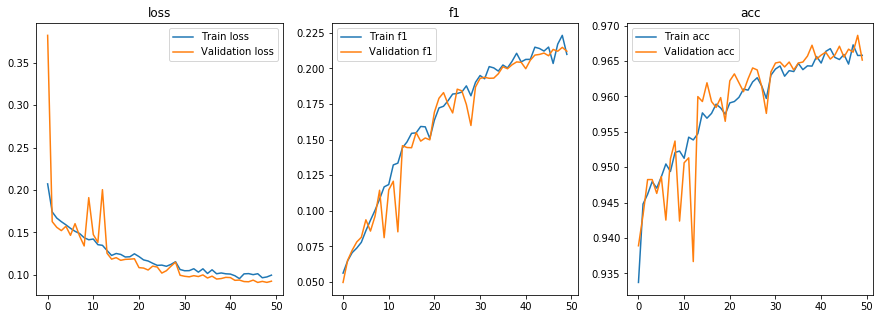

In [11]:
# Learning curve
show_history(history)

# Prediction

In [12]:
model = load_model(DIR + 'InceptionResNetV2.model',custom_objects={'f1': f1})

In [13]:
# Calculate threshold for each class
lastFullValPred = np.empty((0, NUM_CLASS))
lastFullValLabels = np.empty((0, NUM_CLASS))

for i in range(len(train_dataset_info[test_ids.index])): 
    path = train_dataset_info[test_ids.index][i]['path']
    image = data_generator.load_image(path, INPUT_SHAPE)
    scores = model.predict(image[np.newaxis])
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lbl = np.zeros((1,NUM_CLASS))
    lbl[0][train_dataset_info[test_ids.index][i]['labels']] = 1
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], NUM_CLASS))

for j,t in enumerate(tqdm(rng)):
    for i in range(NUM_CLASS):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1
        
T = np.empty(NUM_CLASS)
for i in range(NUM_CLASS):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print(T)

100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s]


[0.282 0.275 0.345 0.282 0.193 0.245 0.454 0.222 0.036 0.035 0.03  0.264
 0.258 0.215 0.348 0.002 0.055 0.106 0.207 0.2   0.132 0.269 0.249 0.355
 0.148 0.381 0.056 0.001]


In [14]:
# Give predictions based on probability and threshold of each class
submit = pd.read_csv(DIR + 'sample_submission.csv')

P = np.zeros((len(submit), NUM_CLASS))
pointer = 0
for name in tqdm(submit['Id']):
    path = os.path.join(DIR + 'test/', name)
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]   #(299,299,3) to (1,299,299,3)  prediction: (1,28) to (,28)
    P[pointer] = score_predict
    pointer += 1

prediction = []
for row in tqdm(range(len(submit))):
    str_label = ''
    for col in range(NUM_CLASS):
        if(P[row, col] < T[col]+1e-4):   # Add a small epsilon to avoid the case a label always exists when its threshold is 0
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())

100%|██████████| 11702/11702 [00:00<00:00, 61101.89it/s]


In [15]:
submit['Predicted'] = prediction
submit.to_csv('submission.csv', index=False)